# Proyek Klasifikasi Gambar: Pneumonia
- **Nama:** [I Gusti Bagus Sutha Arianata Putra]
- **Email:** [ngurahagung909@gmail.com]
- **ID Dicoding:** [bagus sutha]

## Import Semua Packages/Library yang Digunakan

In [ ]:
import zipfile
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

## Data Preparation

### Load Data

In [ ]:
from google.colab import files
files.upload()  # select your kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d artyomkolas/3-kinds-of-pneumonia

zip_path = "3-kinds-of-pneumonia.zip"
extract_path = "/content/dataset_pneumonia"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print(os.listdir(extract_path))

Dataset URL: https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.47G/3.49G [00:35<00:00, 84.4MB/s]
100% 3.49G/3.49G [00:35<00:00, 105MB/s] 
Files extracted to: /content/dataset_pneumonia
['Curated X-Ray Dataset']


In [ ]:
!ls "{extract_path}"
!ls "/content/dataset_pneumonia/Curated X-Ray Dataset"

'Curated X-Ray Dataset'
COVID-19  Normal  Pneumonia-Bacterial  Pneumonia-Viral


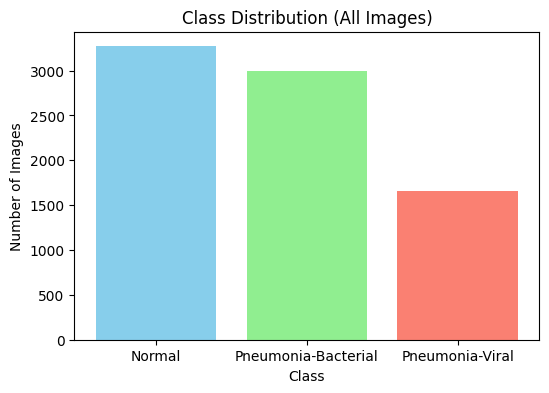

{'Normal': 3270, 'Pneumonia-Bacterial': 3001, 'Pneumonia-Viral': 1656}


In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Paths
dataset_path = "/content/dataset_pneumonia/Curated X-Ray Dataset"
classes = ["Normal", "Pneumonia-Bacterial", "Pneumonia-Viral"]

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Class Distribution (All Images)")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

print(class_counts)


In [ ]:
from PIL import Image
import os

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_path)

Streaming output truncated to the last 5000 lines.
- (1832, 1224)
- (1400, 1072)
- (1504, 1395)
- (1738, 1296)
- (220, 209)
- (2008, 2096)
- (1422, 952)
- (1924, 2102)
- (1306, 1006)
- (1168, 1072)
- (744, 744)
- (1624, 1288)
- (1882, 1812)
- (1200, 960)
- (1554, 1229)
- (1392, 901)
- (660, 494)
- (1248, 664)
- (1492, 1024)
- (2052, 1361)
- (1738, 1430)
- (4280, 3520)
- (1756, 1484)
- (2498, 2057)
- (1090, 842)
- (1936, 1536)
- (1480, 1256)
- (1048, 616)
- (2667, 2280)
- (1064, 560)
- (1294, 1022)
- (544, 524)
- (525, 282)
- (1072, 680)
- (1104, 632)
- (3670, 3308)
- (1392, 1264)
- (960, 624)
- (944, 616)
- (2160, 2304)
- (976, 568)
- (907, 697)
- (1266, 1044)
- (1964, 1611)
- (1016, 640)
- (441, 409)
- (1456, 912)
- (1600, 1600)
- (1496, 984)
- (1592, 921)
- (1344, 856)
- (869, 563)
- (888, 576)
- (828, 525)
- (920, 528)
- (1104, 874)
- (793, 689)
- (1240, 920)
- (1861, 2021)
- (508, 476)
- (1256, 864)
- (1588, 1337)
- (1264, 984)
- (1136, 920)
- (1454, 1229)
- (1168, 872)
- (1208, 94

### Data Preprocessing

#### CLAHE & ROI

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tqdm import tqdm
import concurrent.futures
import zipfile
from pathlib import Path
import time
from collections import defaultdict

# === PATH SETUP ===
input_base = "/content/dataset_pneumonia/Curated X-Ray Dataset"
output_base = "/content/Processed"
model_path = "/content/drive/MyDrive/CAPSTONE/Data/unet_lung_seg.hdf5"

os.makedirs(output_base, exist_ok=True)

# === CONSTANTS ===
TARGET_SIZE = (512, 512)
DILATE_KERNEL = np.ones((15, 15), np.uint8)  # sesuai notebook RSNA
MAX_WORKERS = 8

# === LOAD MODEL ===
print("🔹 Loading U-Net lung segmentation model...")
model = load_model(model_path, compile=False)
print("✅ Model loaded successfully!\n")

# === VISUAL HELPERS (dari notebook RSNA) ===
def add_colored_dilate(image, mask_image, dilate_image):
    # expects BGR images for image, mask_image, dilate_image
    # produce overlay where mask = red, dilate = blue over image
    mask_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_gray)

    mask_coord = np.where(mask != [0, 0, 0])
    dilate_coord = np.where(dilate != [0, 0, 0])

    mask[mask_coord[0], mask_coord[1], :] = [255, 0, 0]     # merah
    dilate[dilate_coord[0], dilate_coord[1], :] = [0, 0, 255] # biru

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)
    return ret

def segment_lung(img, model, target_size=TARGET_SIZE):
    """
    Kembalikan:
     - mask_resized_uint8 : mask binary (0 atau 255) ukuran original
     - mask_dilate_resized_uint8 : dilated mask (0/255) ukuran original
     - lung_result : result (img bitwise_and using dilated mask) ukuran original (BGR)
    """
    try:
        orig_h, orig_w = img.shape[:2]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(gray, target_size)
        img_norm = img_resized.astype(np.float32) / 255.0
        img_input = np.expand_dims(img_norm, axis=(0, -1))  # (1, H, W, 1)

        pred = model.predict(img_input, verbose=0)[0]
        pred_mask = pred[:, :, 0]

        mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255

        # === Bersihkan bintik kecil ===
        min_area_threshold = int((target_size[0] * target_size[1]) * 0.01)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_bin, connectivity=8)
        cleaned_mask_bin = np.zeros_like(mask_bin)

        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
                cleaned_mask_bin[labels == i] = 255
        mask_bin = cleaned_mask_bin

        mask_dilate = cv2.dilate(mask_bin, DILATE_KERNEL, iterations=1)

        mask_resized = cv2.resize(mask_bin, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
        mask_dilate_resized = cv2.resize(mask_dilate, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

        mask_resized_uint8 = mask_resized.astype(np.uint8)
        mask_dilate_resized_uint8 = mask_dilate_resized.astype(np.uint8)

        mask_bgr = cv2.cvtColor(mask_resized_uint8, cv2.COLOR_GRAY2BGR)
        mask_dilate_bgr = cv2.cvtColor(mask_dilate_resized_uint8, cv2.COLOR_GRAY2BGR)

        lung_result = cv2.bitwise_and(img, img, mask=mask_dilate_resized_uint8)

        return mask_bgr, mask_dilate_bgr, lung_result
    except Exception as e:
        print(f"❌ Error during segmentation: {e}")
        h, w = img.shape[:2]
        blank_mask = np.zeros((h, w), dtype=np.uint8)
        return (
            cv2.cvtColor(blank_mask, cv2.COLOR_GRAY2BGR),
            cv2.cvtColor(blank_mask, cv2.COLOR_GRAY2BGR),
            img
        )

# === CLAHE tetap sama ===
def apply_clahe(img):
    """Terapkan CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
    try:
        if len(img.shape) == 3:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            merged = cv2.merge((cl, a, b))
            return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
        else:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            return clahe.apply(img)
    except Exception as e:
        print(f"❌ CLAHE error: {e}")
        return img

def process_image(path_tuple):
    """Pipeline: baca → segmentasi paru → CLAHE pada ROI → simpan hasil ROI CLAHE saja."""
    path, output_folder, folder_name = path_tuple
    try:
        filename = os.path.basename(path)
        stem = Path(filename).stem

        img = cv2.imread(path)
        if img is None:
            return (folder_name, "failed")

        # Segmentasi paru (ROI)
        _, _, lung_img = segment_lung(img, model, target_size=TARGET_SIZE)

        # Terapkan CLAHE pada hasil ROI
        clahe_img = apply_clahe(lung_img)

        # Simpan hanya hasil ROI yang sudah CLAHE
        save_lung_clahe = os.path.join(output_folder, f"{stem}_lung_clahe.png")
        cv2.imwrite(save_lung_clahe, clahe_img)

        return (folder_name, "success")
    except Exception as e:
        print(f"❌ process_image error for {path}: {e}")
        return (folder_name, "failed")

# === PROCESSING ===
folders = ["Normal", "Pneumonia-Bacterial", "Pneumonia-Viral"]
stats = defaultdict(lambda: {"total": 0, "success": 0, "failed": 0})

print("🚀 Starting parallel processing...\n")
start_time = time.time()

for folder in folders:
    input_folder = os.path.join(input_base, folder)
    output_folder = os.path.join(output_base, folder)
    os.makedirs(output_folder, exist_ok=True)

    images = [os.path.join(input_folder, f) for f in os.listdir(input_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    stats[folder]["total"] = len(images)

    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        for result in tqdm(executor.map(process_image, [(img, output_folder, folder) for img in images]),
                           total=len(images),
                           desc=f"Processing {folder}",
                           ncols=90):
            if result[1] == "success":
                stats[result[0]]["success"] += 1
            else:
                stats[result[0]]["failed"] += 1

# === ZIP RESULT ===
print("\n📦 Zipping processed dataset...")
zip_path = "/content/drive/MyDrive/CAPSTONE/Dataset/Processed.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_base):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_base)
            zipf.write(file_path, arcname)

# === REPORT ===
elapsed_time = time.time() - start_time
print("\n" + "="*70)
print("📊 RINGKASAN PEMROSESAN DATASET".center(70))
print("="*70)
total_all = 0
success_all = 0
failed_all = 0

for folder in folders:
    t = stats[folder]["total"]
    s = stats[folder]["success"]
    f = stats[folder]["failed"]
    total_all += t
    success_all += s
    failed_all += f

    print(f"\n📁 {folder}")
    print(f"  Total gambar   : {t}")
    print(f"  Berhasil proses: {s}")
    print(f"  Gagal / dilewati: {f}")

print("\n" + "-"*70)
print(f"🧾 TOTAL SEMUA KELAS")
print(f"  Total gambar   : {total_all}")
print(f"  Berhasil proses: {success_all}")
print(f"  Gagal / dilewati: {failed_all}")
print(f"  Durasi total   : {elapsed_time/60:.2f} menit")
print("-"*70)
print(f"📂 Folder hasil: {output_base}")
print(f"🗜️ File ZIP: {zip_path}")
print("="*70)
print("✅ Semua gambar selesai diproses!\n")


🔹 Loading U-Net lung segmentation model...
✅ Model loaded successfully!

🚀 Starting parallel processing...



Processing Pneumonia-Viral: 100%|█████████████████████| 1656/1656 [03:40<00:00,  7.51it/s]



📦 Zipping processed dataset...

                    📊 RINGKASAN PEMROSESAN DATASET                    

📁 Normal
  Total gambar   : 3270
  Berhasil proses: 3270
  Gagal / dilewati: 0

📁 Pneumonia-Bacterial
  Total gambar   : 3001
  Berhasil proses: 3001
  Gagal / dilewati: 0

📁 Pneumonia-Viral
  Total gambar   : 1656
  Berhasil proses: 1656
  Gagal / dilewati: 0

----------------------------------------------------------------------
🧾 TOTAL SEMUA KELAS
  Total gambar   : 7927
  Berhasil proses: 7927
  Gagal / dilewati: 0
  Durasi total   : 25.20 menit
----------------------------------------------------------------------
📂 Folder hasil: /content/Processed
🗜️ File ZIP: /content/drive/MyDrive/CAPSTONE/Dataset/Processed.zip
✅ Semua gambar selesai diproses!



#### Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Paths
dataset_path = "/content/dataset_pneumonia/Curated X-Ray Dataset"
classes = ["Normal", "Pneumonia-Bacterial", "Pneumonia-Viral"]

# Parameters
img_height, img_width = 224, 224
batch_size = 32
validation_split = 0.3  # 30% for val + test

# Data generator dengan augmentasi
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,         # shear kecil
    fill_mode='nearest',
    validation_split=validation_split
)

# Training generator (70%)
train_generator = datagen_train.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=classes,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

# Generator untuk validation/test (30%) -> biasanya tidak augmentasi
datagen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

val_generator = datagen_val.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=classes,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    color_mode='rgb'
)

# Convert validation generator ke array
temp_images, temp_labels = [], []
for i in range(len(val_generator)):
    imgs, labels = val_generator[i]
    temp_images.append(imgs)
    temp_labels.append(labels)

temp_images = np.concatenate(temp_images, axis=0)
temp_labels = np.concatenate(temp_labels, axis=0)

print("Validation images shape:", temp_images.shape)
print("Validation labels shape:", temp_labels.shape)

Found 5550 images belonging to 3 classes.
Found 2377 images belonging to 3 classes.
Validation images shape: (2377, 224, 224, 3)
Validation labels shape: (2377,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# ============================
# 🔹 Train set distribusi
# ============================
train_labels = train_generator.classes  # integer label
unique, counts = np.unique(train_labels, return_counts=True)
# Mapping indeks ke nama kelas
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

print("Train set class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {idx_to_class[u]} ({u}): {c} samples")

# ============================
# 🔹 Validation & Test split (50%-50% dari temp)
# ============================
# Membagi validation data menjadi 50% val dan 50% test dengan distribusi seimbang
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels,
    test_size=0.5,                 # separuh dari data validation
    stratify=temp_labels,          # pastikan distribusi per kelas sama
    random_state=42                # agar hasil konsisten
)

# Cek distribusi hasilnya
def print_distribution(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} class distribution:")
    for u, c in zip(unique, counts):
        print(f"Class {idx_to_class[u]} ({u}): {c} samples")

print_distribution(val_labels, "Validation")
print_distribution(test_labels, "Test")


Train set class distribution:
Class Normal (0): 2289 samples
Class Pneumonia-Bacterial (1): 2101 samples
Class Pneumonia-Viral (2): 1160 samples

Validation class distribution:
Class Normal (0.0): 490 samples
Class Pneumonia-Bacterial (1.0): 450 samples
Class Pneumonia-Viral (2.0): 248 samples

Test class distribution:
Class Normal (0.0): 491 samples
Class Pneumonia-Bacterial (1.0): 450 samples
Class Pneumonia-Viral (2.0): 248 samples


#### Class Weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# ============================
# 🔹 Ambil label dari train_generator
# ============================
train_labels = train_generator.classes  # sudah berupa integer

# ============================
# 🔹 Hitung class weights
# ============================
classes = np.unique(train_labels)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# Buat dictionary class_weight
class_weights = dict(zip(classes, weights))

print("Class Weights Dictionary:", class_weights)

# ============================
# 🔹 Print mapping label → class weight
# ============================
# Pastikan mapping indeks → nama kelas ada
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

print("\nMapping label → class weight:")
for cls in classes:
    print(f"Class {cls} ({idx_to_class[cls]}): weight = {class_weights[cls]:.8f}")

Class Weights Dictionary: {np.int32(0): np.float64(0.8082131935342944), np.int32(1): np.float64(0.880533079485959), np.int32(2): np.float64(1.5948275862068966)}

Mapping label → class weight:
Class 0 (Normal): weight = 0.80821319
Class 1 (Pneumonia-Bacterial): weight = 0.88053308
Class 2 (Pneumonia-Viral): weight = 1.59482759


## Modelling

##### CNN

In [ ]:
# ============================
# 🔹 MODEL CNN
# ============================
model_cnn = Sequential([
    # Layer 1
    Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(img_width,img_height,1)),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),

    # Layer 2
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),

    # Layer 3
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),

    # Layer 4
    Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),

    # Layer 5
    Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),

    # Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# ============================
# 🔹 Compile Model
# ============================
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()


In [ ]:
# ============================
# 🔹 Callbacks
# ============================
checkpoint_cb = ModelCheckpoint(
    'best_model_cnn.h5',          # simpan model terbaik
    save_best_only=True,
    monitor='val_loss',       # monitor loss pada validation
    mode='min',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,              # hentikan training jika tidak ada perbaikan selama 10 epoch
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,               # turunkan learning rate menjadi setengah
    patience=5,               # jika tidak ada perbaikan selama 5 epoch
    min_lr=1e-6,              # minimum learning rate
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

In [ ]:
# ============================
# 🔹 Training dengan validation
# ============================
history = model_cnn.fit(
    train_generator,
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights  # sudah Python dict
)


# ============================
# 🔹 Evaluasi model di test set
# ============================
test_loss, test_acc = model_cnn.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Buat folder hasil
results_dir = "/content/results"
os.makedirs(results_dir, exist_ok=True)

model_name = "model_cnn"  # nama model untuk ditambahkan di file

# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Simpan plot
acc_loss_path = os.path.join(results_dir, f"accuracy_loss_plot_{model_name}.png")
plt.savefig(acc_loss_path)
plt.show()
print(f"Accuracy/Loss plot saved at: {acc_loss_path}")

# Confusion Matrix
y_pred_prob = model_cnn.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # langsung gunakan

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

# Simpan confusion matrix
cm_path = os.path.join(results_dir, f"confusion_matrix_{model_name}.png")
plt.savefig(cm_path)
plt.show()
print(f"Confusion matrix saved at: {cm_path}")

# ============================
# 🔹 Simpan Model
# ============================

# Format HDF5 (.h5)
model_h5_path = os.path.join(results_dir, f"{model_name}.h5")
model_cnn.save(model_h5_path)
print(f"Model saved as HDF5 at: {model_h5_path}")

# Format native Keras (.keras)
model_keras_path = os.path.join(results_dir, f"{model_name}.keras")
model_cnn.save(model_keras_path)
print(f"Model saved as native Keras at: {model_keras_path}")

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ============================
# 🔹 Evaluasi Model di Test Set
# ============================

classes = ["Normal", "Pneumonia Bacterial", "Pneumonia Viral"]

# Prediksi probabilitas dan label
y_pred_prob = model_cnn.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # untuk sparse label

# Hitung metrik evaluasi
test_acc = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Cetak hasil
print("🔹 Evaluation Results:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")

# Pastikan classes dalam bentuk list of string
classes = [str(c) for c in classes]

# Lalu panggil ulang classification_report
report = classification_report(y_true, y_pred, target_names=classes)
print("\nDetailed Classification Report:")
print(report)

# Simpan laporan ke file
report_path = os.path.join(results_dir, f"evaluation_report_{model_name}.txt")
with open(report_path, "w") as f:
    f.write("🔹 Evaluation Results\n")
    f.write(f"Accuracy : {test_acc:.4f}\n")
    f.write(f"Precision: {test_precision:.4f}\n")
    f.write(f"Recall   : {test_recall:.4f}\n")
    f.write(f"F1-Score : {test_f1:.4f}\n\n")
    f.write("🔹 Classification Report per Class\n")
    f.write(report)

print(f"Evaluation report saved at: {report_path}")


#### VGG16

In [ ]:
x_batch, y_batch = next(val_generator)
print("Train batch shape:", x_batch.shape)

if x_batch.shape[-1] == 3:
    print("✅ Input sudah RGB (3 channel)")
else:
    print("⚠️ Masih grayscale (1 channel)")


Train batch shape: (32, 224, 224, 3)
✅ Input sudah RGB (3 channel)


In [ ]:
# ============================
# 🔹 MODEL VGG16
# ============================

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze semua layer VGG16 agar tidak ikut dilatih di awal
for layer in base_model.layers:
    layer.trainable = False

model_vgg = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# ============================
# 🔹 Compile Model
# ============================
model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# ============================
# 🔹 Callbacks
# ============================
checkpoint_cb = ModelCheckpoint(
    'best_model_VGG16.h5',          # simpan model terbaik
    save_best_only=True,
    monitor='val_loss',       # monitor loss pada validation
    mode='min',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,              # hentikan training jika tidak ada perbaikan selama 10 epoch
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,               # turunkan learning rate menjadi setengah
    patience=5,               # jika tidak ada perbaikan selama 5 epoch
    min_lr=1e-6,              # minimum learning rate
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

In [ ]:
# ============================
# 🔹 Training dengan validation
# ============================
history = model_vgg.fit(
    train_generator,
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights  # sudah Python dict
)


# ============================
# 🔹 Evaluasi model di test set
# ============================
test_loss, test_acc = model_vgg.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5944 - loss: 0.8968
Epoch 1: val_loss improved from inf to 0.58872, saving model to best_model_VGG16.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 158s 890ms/step - accuracy: 0.5947 - loss: 0.8961 - val_accuracy: 0.7483 - val_loss: 0.5887 - learning_rate: 1.0000e-04
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.6876 - loss: 0.6828
Epoch 2: val_loss improved from 0.58872 to 0.57727, saving model to best_model_VGG16.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 140s 802ms/step - accuracy: 0.6877 - loss: 0.6827 - val_accuracy: 0.7887 - val_loss: 0.5773 - learning_rate: 1.0000e-04
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.7138 - loss: 0.6551
Epoch 3: val_loss improved from 0.57727 to 0.47386, saving model to best_model_VGG16.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 782ms/step - accuracy: 0.7138 - loss: 0.6551 - val_accuracy: 0.8426 - val_loss: 0.4739 - learning_rate: 1.0000e-04
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7304 - loss: 0.6312
Epoch 4: val_loss did not improve from 0.47386
174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 783ms/step - accuracy: 0.7304 - loss: 0.6312 - val_accuracy: 0.8039 - val_loss: 0.5585 - learning_rate: 1.0000e-04
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7570 - loss: 0.5929
Epoch 5: val_loss did not improve from 0.47386
174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 783ms/step - accuracy: 0.7569 - loss: 0.5930 - val_accuracy: 0.8123 - val_loss: 0.5238 - learning_rate: 1.0000e-04
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.7447 - loss: 0.6149
Epoch 6: val_loss did not improve from 0.47386
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 774ms/step - accuracy: 0.7447 - loss: 0.6148 - val_accuracy: 0.8123 - val_loss: 0.4979 - learning_rate: 1.0000e-04

174/174 ━━━━━━━━━━━━━━━━━━━━ 134s 771ms/step - accuracy: 0.7547 - loss: 0.6004 - val_accuracy: 0.8502 - val_loss: 0.4349 - learning_rate: 1.0000e-04
Epoch 9/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.7589 - loss: 0.6020
Epoch 9: val_loss did not improve from 0.43491
174/174 ━━━━━━━━━━━━━━━━━━━━ 134s 768ms/step - accuracy: 0.7589 - loss: 0.6019 - val_accuracy: 0.8258 - val_loss: 0.4863 - learning_rate: 1.0000e-04
Epoch 10/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7541 - loss: 0.5974
Epoch 10: val_loss did not improve from 0.43491
174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 783ms/step - accuracy: 0.7541 - loss: 0.5974 - val_accuracy: 0.7980 - val_loss: 0.5776 - learning_rate: 1.0000e-04
Epoch 11/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.7592 - loss: 0.5879
Epoch 11: val_loss did not improve from 0.43491
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 778ms/step - accuracy: 0.7592 - loss: 0.5880 - val_accuracy: 0.8325 - val_loss: 0.4679 - learning_rate: 1.0000

174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 782ms/step - accuracy: 0.7635 - loss: 0.5828 - val_accuracy: 0.8493 - val_loss: 0.4235 - learning_rate: 1.0000e-04
Epoch 13/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.7548 - loss: 0.5790
Epoch 13: val_loss improved from 0.42346 to 0.40649, saving model to best_model_VGG16.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 142s 817ms/step - accuracy: 0.7548 - loss: 0.5789 - val_accuracy: 0.8577 - val_loss: 0.4065 - learning_rate: 1.0000e-04
Epoch 14/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.7651 - loss: 0.5766
Epoch 14: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 141s 811ms/step - accuracy: 0.7651 - loss: 0.5766 - val_accuracy: 0.8485 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 15/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7704 - loss: 0.5632
Epoch 15: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 138s 790ms/step - accuracy: 0.7703 - loss: 0.5632 - val_accuracy: 0.8224 - val_loss: 0.5087 - learning_rate: 1.0000e-04
Epoch 16/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7547 - loss: 0.5886
Epoch 16: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 137s 790ms/step - accuracy: 0.7547 - loss: 0.5885 - val_accuracy: 0.8258 - val_loss: 0.4676 - learning_rate: 1.00

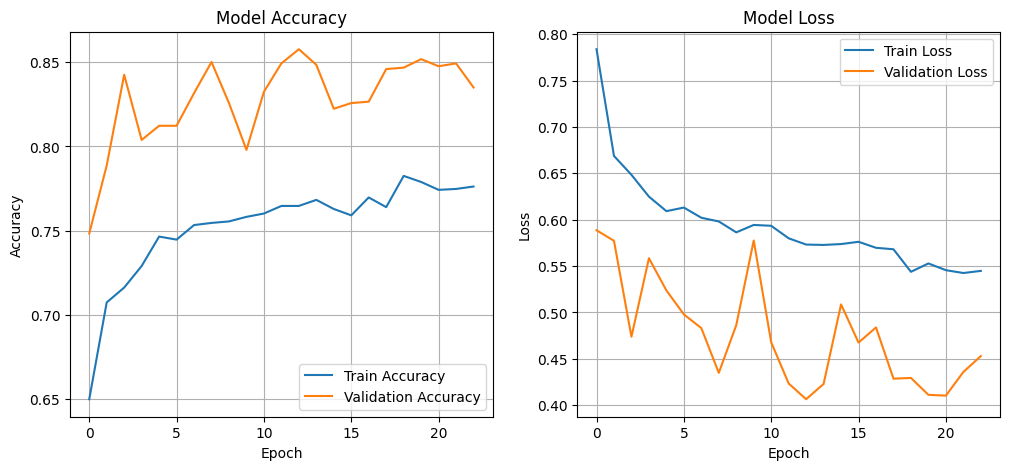

Accuracy/Loss plot saved at: /content/results/accuracy_loss_plot_model_vgg16.png
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step


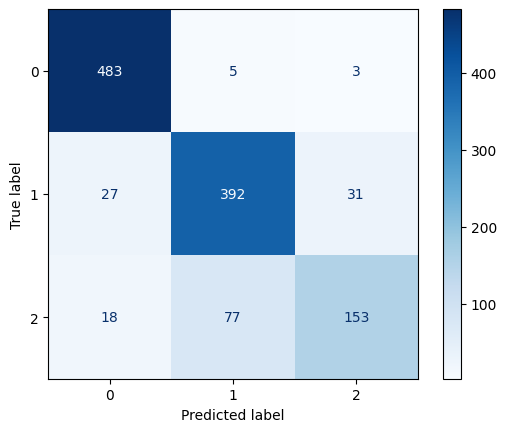

Confusion matrix saved at: /content/results/confusion_matrix_model_vgg16.png
Model saved as HDF5 at: /content/results/model_vgg16.h5
Model saved as native Keras at: /content/results/model_vgg16.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step
🔹 Evaluation Results:
Accuracy : 0.8646
Precision: 0.8614
Recall   : 0.8646
F1-Score : 0.8593

Detailed Classification Report:
                     precision    recall  f1-score   support

             Normal       0.91      0.98      0.95       491
Pneumonia Bacterial       0.83      0.87      0.85       450
    Pneumonia Viral       0.82      0.62      0.70       248

           accuracy                           0.86      1189
          macro avg       0.85      0.82      0.83      1189
       weighted avg       0.86      0.86      0.86      1189

Evaluation report saved at: /content/results/evaluation_report_model_vgg16.txt


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Buat folder hasil
results_dir = "/content/results"
os.makedirs(results_dir, exist_ok=True)

model_name = "model_vgg16"  # nama model untuk ditambahkan di file

# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Simpan plot
acc_loss_path = os.path.join(results_dir, f"accuracy_loss_plot_{model_name}.png")
plt.savefig(acc_loss_path)
plt.show()
print(f"Accuracy/Loss plot saved at: {acc_loss_path}")

# Confusion Matrix
y_pred_prob = model_vgg.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # langsung gunakan

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

# Simpan confusion matrix
cm_path = os.path.join(results_dir, f"confusion_matrix_{model_name}.png")
plt.savefig(cm_path)
plt.show()
print(f"Confusion matrix saved at: {cm_path}")

# ============================
# 🔹 Simpan Model
# ============================

# Format HDF5 (.h5)
model_h5_path = os.path.join(results_dir, f"{model_name}.h5")
model_vgg.save(model_h5_path)
print(f"Model saved as HDF5 at: {model_h5_path}")

# Format native Keras (.keras)
model_keras_path = os.path.join(results_dir, f"{model_name}.keras")
model_vgg.save(model_keras_path)
print(f"Model saved as native Keras at: {model_keras_path}")

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ============================
# 🔹 Evaluasi Model di Test Set
# ============================

classes = ["Normal", "Pneumonia Bacterial", "Pneumonia Viral"]

# Prediksi probabilitas dan label
y_pred_prob = model_vgg.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # untuk sparse label

# Hitung metrik evaluasi
test_acc = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Cetak hasil
print("🔹 Evaluation Results:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")

# Pastikan classes dalam bentuk list of string
classes = [str(c) for c in classes]

# Lalu panggil ulang classification_report
report = classification_report(y_true, y_pred, target_names=classes)
print("\nDetailed Classification Report:")
print(report)

# Simpan laporan ke file
report_path = os.path.join(results_dir, f"evaluation_report_{model_name}.txt")
with open(report_path, "w") as f:
    f.write("🔹 Evaluation Results\n")
    f.write(f"Accuracy : {test_acc:.4f}\n")
    f.write(f"Precision: {test_precision:.4f}\n")
    f.write(f"Recall   : {test_recall:.4f}\n")
    f.write(f"F1-Score : {test_f1:.4f}\n\n")
    f.write("🔹 Classification Report per Class\n")
    f.write(report)

print(f"Evaluation report saved at: {report_path}")


In [ ]:
# Unfreeze beberapa layer terakhir VGG16
for layer in model_vgg.layers[0].layers[-8:]:
    layer.trainable = True

# Recompile model dengan learning rate lebih kecil
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
fine_tune_history = model_vgg.fit(
    train_generator,
    validation_data=(val_images, val_labels),
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights  # sudah Python dict
)

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.7799 - loss: 0.5459
Epoch 1: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 170s 933ms/step - accuracy: 0.7799 - loss: 0.5459 - val_accuracy: 0.7761 - val_loss: 0.5936 - learning_rate: 1.0000e-05
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7917 - loss: 0.5241
Epoch 2: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 150s 863ms/step - accuracy: 0.7917 - loss: 0.5240 - val_accuracy: 0.8527 - val_loss: 0.4219 - learning_rate: 1.0000e-05
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.7849 - loss: 0.5331
Epoch 3: val_loss did not improve from 0.40649
174/174 ━━━━━━━━━━━━━━━━━━━━ 146s 839ms/step - accuracy: 0.7849 - loss: 0.5330 - val_accuracy: 0.8418 - val_loss: 0.4616 - learning_rate: 1.0000e-05
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7959 - loss: 0.5135
Epoch 4: val_loss did not improve from 0.40649
174/174 ━━━━━

174/174 ━━━━━━━━━━━━━━━━━━━━ 143s 823ms/step - accuracy: 0.7991 - loss: 0.4840 - val_accuracy: 0.8611 - val_loss: 0.3836 - learning_rate: 1.0000e-05
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.7940 - loss: 0.5077
Epoch 6: val_loss improved from 0.38359 to 0.35847, saving model to best_model_VGG16.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 148s 849ms/step - accuracy: 0.7940 - loss: 0.5076 - val_accuracy: 0.8746 - val_loss: 0.3585 - learning_rate: 1.0000e-05
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7972 - loss: 0.4928
Epoch 7: val_loss did not improve from 0.35847
174/174 ━━━━━━━━━━━━━━━━━━━━ 152s 871ms/step - accuracy: 0.7972 - loss: 0.4927 - val_accuracy: 0.8636 - val_loss: 0.4034 - learning_rate: 1.0000e-05
Epoch 8/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.8069 - loss: 0.4804
Epoch 8: val_loss did not improve from 0.35847
174/174 ━━━━━━━━━━━━━━━━━━━━ 143s 823ms/step - accuracy: 0.8069 - loss: 0.4804 - val_accuracy: 0.8316 - val_loss: 0.4546 - learning_rate: 1.0000e-05
Epoch 9/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.8136 - loss: 0.4579
Epoch 9: val_loss did not improve from 0.35847
174/174 ━━━━━━━━━━━━━━━━━━━━ 145s 830ms/step - accuracy: 0.8136 - loss: 0.4580 - val_accuracy: 0.8628 - val_loss: 0.3791 - learning_rate: 1.0000e-05

174/174 ━━━━━━━━━━━━━━━━━━━━ 148s 849ms/step - accuracy: 0.8159 - loss: 0.4577 - val_accuracy: 0.8754 - val_loss: 0.3500 - learning_rate: 1.0000e-05
Epoch 11/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.8160 - loss: 0.4503
Epoch 11: val_loss did not improve from 0.35004
174/174 ━━━━━━━━━━━━━━━━━━━━ 144s 828ms/step - accuracy: 0.8159 - loss: 0.4503 - val_accuracy: 0.8502 - val_loss: 0.4194 - learning_rate: 1.0000e-05
Epoch 12/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8246 - loss: 0.4455
Epoch 12: val_loss did not improve from 0.35004
174/174 ━━━━━━━━━━━━━━━━━━━━ 143s 821ms/step - accuracy: 0.8245 - loss: 0.4455 - val_accuracy: 0.8350 - val_loss: 0.4173 - learning_rate: 1.0000e-05
Epoch 13/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8198 - loss: 0.4316
Epoch 13: val_loss did not improve from 0.35004
174/174 ━━━━━━━━━━━━━━━━━━━━ 146s 838ms/step - accuracy: 0.8198 - loss: 0.4317 - val_accuracy: 0.8434 - val_loss: 0.4222 - learning_rate: 1.00

In [ ]:
result = '/content/results'

destination = '/content/drive/MyDrive/CAPSTONE/Data'

In [ ]:
import shutil

result = '/content/results'
destination = '/content/drive/MyDrive/CAPSTONE/Data'

# Copy seluruh folder beserta isinya
shutil.copytree(result, destination, dirs_exist_ok=True)

print(f"✅ Folder '{result}' berhasil disalin ke '{destination}'")


✅ Folder '/content/results' berhasil disalin ke '/content/drive/MyDrive/CAPSTONE/Data'


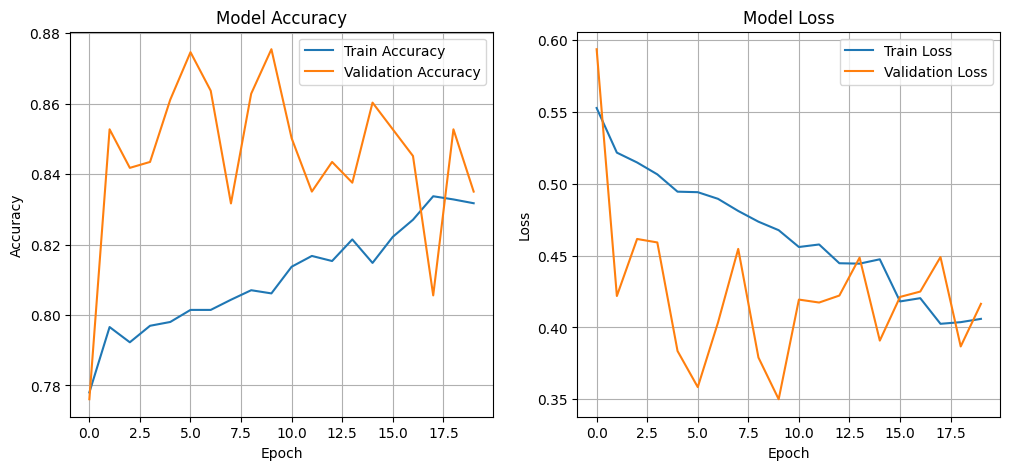

Accuracy/Loss plot saved at: /content/results/accuracy_loss_plot_model_vgg16_finetuned.png
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step


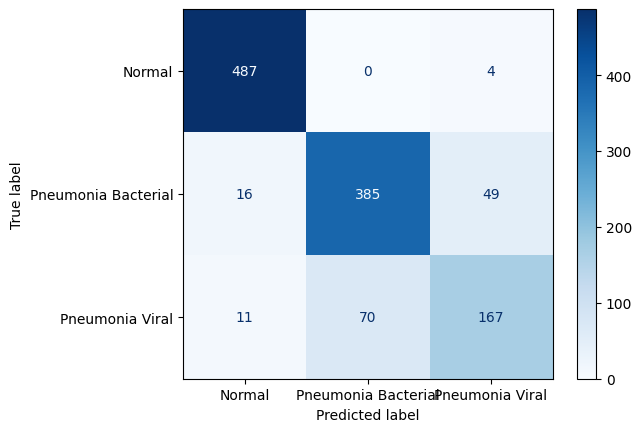

Confusion matrix saved at: /content/results/confusion_matrix_model_vgg16_finetuned.png
Model saved as HDF5 at: /content/results/model_vgg16_finetuned.h5
Model saved as native Keras at: /content/results/model_vgg16_finetuned.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step
🔹 Evaluation Results:
Accuracy : 0.8738
Precision: 0.8698
Recall   : 0.8738
F1-Score : 0.8711

Detailed Classification Report:
                     precision    recall  f1-score   support

             Normal       0.95      0.99      0.97       491
Pneumonia Bacterial       0.85      0.86      0.85       450
    Pneumonia Viral       0.76      0.67      0.71       248

           accuracy                           0.87      1189
          macro avg       0.85      0.84      0.84      1189
       weighted avg       0.87      0.87      0.87      1189

Evaluation report saved at: /content/results/evaluation_report_model_vgg16_finetuned.txt


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Buat folder hasil
results_dir = "/content/results"
os.makedirs(results_dir, exist_ok=True)

model_name = "model_vgg16_finetuned"  # nama model untuk ditambahkan di file

# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Simpan plot
acc_loss_path = os.path.join(results_dir, f"accuracy_loss_plot_{model_name}.png")
plt.savefig(acc_loss_path)
plt.show()
print(f"Accuracy/Loss plot saved at: {acc_loss_path}")

# Confusion Matrix
y_pred_prob = model_vgg.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # langsung gunakan

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

# Simpan confusion matrix
cm_path = os.path.join(results_dir, f"confusion_matrix_{model_name}.png")
plt.savefig(cm_path)
plt.show()
print(f"Confusion matrix saved at: {cm_path}")

# ============================
# 🔹 Simpan Model
# ============================

# Format HDF5 (.h5)
model_h5_path = os.path.join(results_dir, f"{model_name}.h5")
model_vgg.save(model_h5_path)
print(f"Model saved as HDF5 at: {model_h5_path}")

# Format native Keras (.keras)
model_keras_path = os.path.join(results_dir, f"{model_name}.keras")
model_vgg.save(model_keras_path)
print(f"Model saved as native Keras at: {model_keras_path}")

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ============================
# 🔹 Evaluasi Model di Test Set
# ============================

classes = ["Normal", "Pneumonia Bacterial", "Pneumonia Viral"]

# Prediksi probabilitas dan label
y_pred_prob = model_vgg.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_labels  # untuk sparse label

# Hitung metrik evaluasi
test_acc = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Cetak hasil
print("🔹 Evaluation Results:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")

# Pastikan classes dalam bentuk list of string
classes = [str(c) for c in classes]

# Lalu panggil ulang classification_report
report = classification_report(y_true, y_pred, target_names=classes)
print("\nDetailed Classification Report:")
print(report)

# Simpan laporan ke file
report_path = os.path.join(results_dir, f"evaluation_report_{model_name}.txt")
with open(report_path, "w") as f:
    f.write("🔹 Evaluation Results\n")
    f.write(f"Accuracy : {test_acc:.4f}\n")
    f.write(f"Precision: {test_precision:.4f}\n")
    f.write(f"Recall   : {test_recall:.4f}\n")
    f.write(f"F1-Score : {test_f1:.4f}\n\n")
    f.write("🔹 Classification Report per Class\n")
    f.write(report)

print(f"Evaluation report saved at: {report_path}")


## Evaluasi dan Visualisasi

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
import re


In [ ]:
acc_loss_plot_cnn = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_cnn.png'
acc_loss_plot_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_vgg16.png'
acc_loss_plot_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_vgg16_finetuned.png'

confusion_matrix_cnn = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_cnn.png'
confusion_matrix_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_vgg16.png'
confusion_matrix_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_vgg16_finetuned.png'

evaluation_report_cnn = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_cnn.txt'
evaluation_report_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_vgg16.txt'
evaluation_report_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_vgg16_finetuned.txt'

📈 Accuracy & Loss Plot — CNN


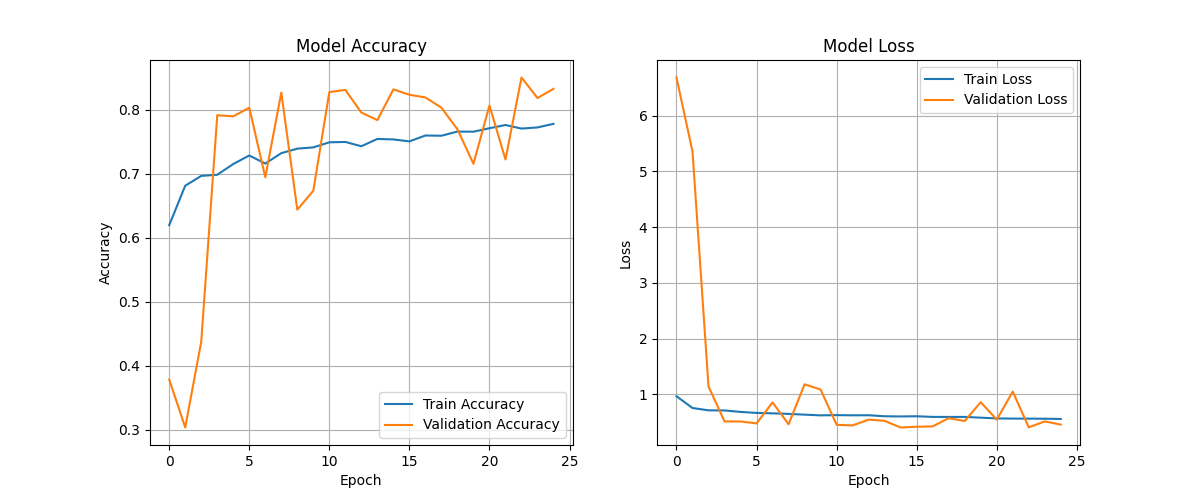

📈 Accuracy & Loss Plot — VGG16 (Transfer Learning)


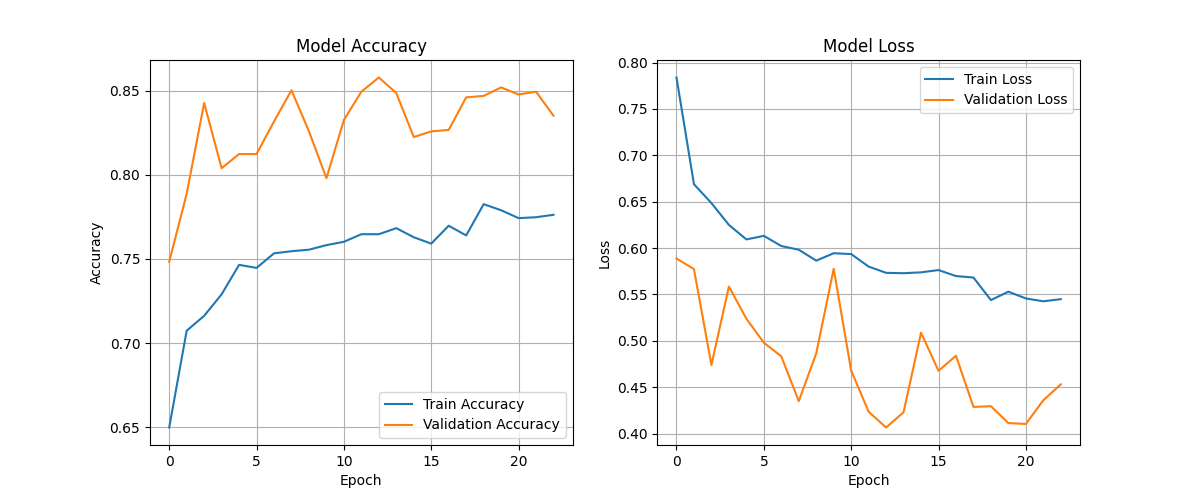

📈 Accuracy & Loss Plot — VGG16 (Fine-Tuned)


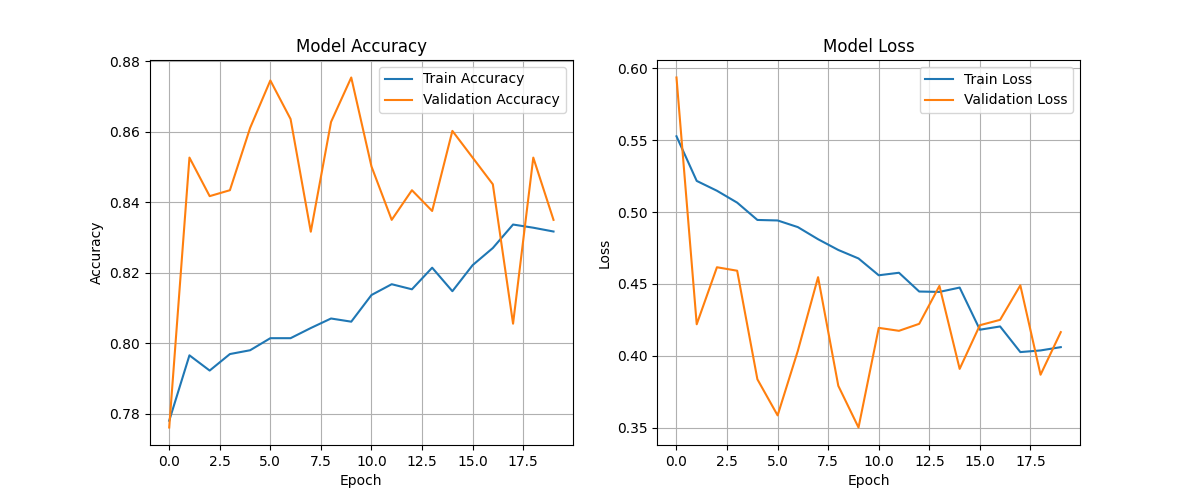

In [ ]:
# Path file
acc_loss_plot_cnn = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_cnn.png'
acc_loss_plot_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_vgg16.png'
acc_loss_plot_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/accuracy_loss_plot_model_vgg16_finetuned.png'

# Display the plots
print("📈 Accuracy & Loss Plot — CNN")
display(Image(filename=acc_loss_plot_cnn))

print("📈 Accuracy & Loss Plot — VGG16 (Transfer Learning)")
display(Image(filename=acc_loss_plot_vgg16))

print("📈 Accuracy & Loss Plot — VGG16 (Fine-Tuned)")
display(Image(filename=acc_loss_plot_vgg16_finetuned))


/tmp/ipython-input-310505534.py:21: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


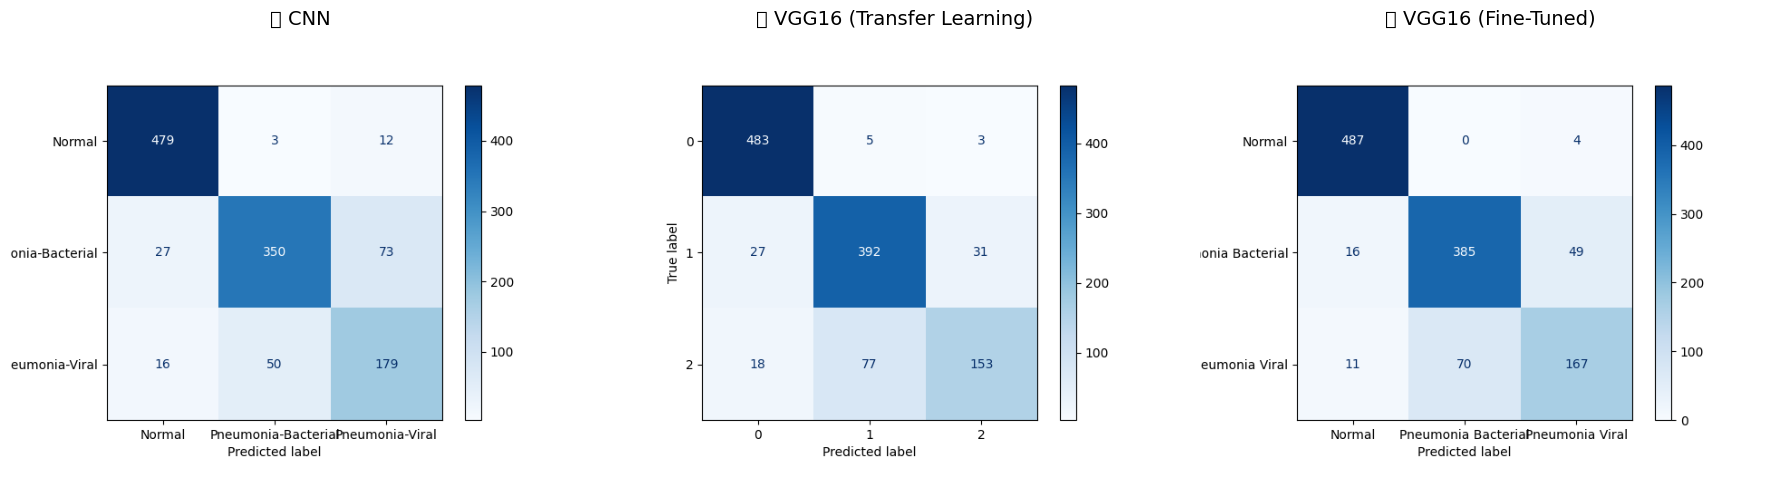

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths
confusion_matrix_cnn = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_cnn.png'
confusion_matrix_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_vgg16.png'
confusion_matrix_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/confusion_matrix_model_vgg16_finetuned.png'

confusion_matrices = [confusion_matrix_cnn, confusion_matrix_vgg16, confusion_matrix_vgg16_finetuned]
titles = ['CNN', 'VGG16 (Transfer Learning)', 'VGG16 (Fine-Tuned)']

# Setup figure 1x3
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    img = Image.open(confusion_matrices[i])
    ax.imshow(img)
    ax.set_title(f'🧩 {titles[i]}', fontsize=14)
    ax.axis('off')  # Hapus axis

plt.tight_layout()
plt.show()


In [ ]:
# Paths ke report
evaluation_report_cnn = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_cnn.txt'
evaluation_report_vgg16 = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_vgg16.txt'
evaluation_report_vgg16_finetuned = '/content/drive/MyDrive/CAPSTONE/Data/evaluation_report_model_vgg16_finetuned.txt'

# Fungsi untuk membaca dan menampilkan report
def display_classification_report(filepath, model_name):
    print(f"\n=== Classification Report: {model_name} ===\n")
    with open(filepath, 'r') as f:
        print(f.read())

# Tampilkan ketiga report
display_classification_report(evaluation_report_cnn, "CNN")
display_classification_report(evaluation_report_vgg16, "VGG16")
display_classification_report(evaluation_report_vgg16_finetuned, "VGG16 Finetuned")



=== Classification Report: CNN ===

🔹 Evaluation Results
Accuracy : 0.8478
Precision: 0.8497
Recall   : 0.8478
F1-Score : 0.8473

🔹 Classification Report per Class
                     precision    recall  f1-score   support

             Normal       0.92      0.97      0.94       494
Pneumonia Bacterial       0.87      0.78      0.82       450
    Pneumonia Viral       0.68      0.73      0.70       245

           accuracy                           0.85      1189
          macro avg       0.82      0.83      0.82      1189
       weighted avg       0.85      0.85      0.85      1189


=== Classification Report: VGG16 ===

🔹 Evaluation Results
Accuracy : 0.8646
Precision: 0.8614
Recall   : 0.8646
F1-Score : 0.8593

🔹 Classification Report per Class
                     precision    recall  f1-score   support

             Normal       0.91      0.98      0.95       491
Pneumonia Bacterial       0.83      0.87      0.85       450
    Pneumonia Viral       0.82      0.62      0.70    

🧠 Insight:
Berdasarkan data, model VGG16 fine-tuned (Akurasi Tes 87.38%) terbukti paling efektif, melampaui VGG16 transfer learning standar (Akurasi Tes 86.46%) karena penyesuaian 8 layer terakhirnya.

## Konversi Model

In [ ]:
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE/Data/model_cnn.keras')
model_vgg16 = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE/Data/model_vgg16.keras')
model_vgg16_finetuned = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE/Data/model_vgg16_finetuned.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
import tensorflow as tf

# Load model .keras
model_vgg16_finetuned = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE/Data/model_vgg16_finetuned.keras')

# Simpan ulang ke format .h5
model_vgg16_finetuned.save('/content/drive/MyDrive/CAPSTONE/Data/model_vgg16_finetuned.h5', save_format='h5')

print("✅ Semua model berhasil dikonversi ke format .h5!")


ValueError: File not found: filepath=/content/drive/MyDrive/CAPSTONE/Data/model_vgg16_finetuned.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Folder tujuan SavedModel
savedmodel_dir = '/content/drive/MyDrive/CAPSTONE/Data/SavedModel/'

# CNN
model_cnn.export(f'{savedmodel_dir}model_cnn')

# VGG16
model_vgg16.export(f'{savedmodel_dir}model_vgg16')

# VGG16 Finetuned
model_vgg16_finetuned.export(f'{savedmodel_dir}model_vgg16_finetuned')


Saved artifact at '/content/drive/MyDrive/CAPSTONE/Data/SavedModel/model_cnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139409307030480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307032784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307033552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307030288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307031824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307025488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307033744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307033360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307036624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409307036816: TensorSpec(shape=(), dtyp

In [ ]:
import tensorflow as tf
import os

# Folder SavedModel
savedmodel_dir = '/content/drive/MyDrive/CAPSTONE/Data/SavedModel/'

# Folder TFLite output
tflite_dir = '/content/drive/MyDrive/CAPSTONE/Data/TFLite/'

# Pastikan folder TFLite ada
os.makedirs(tflite_dir, exist_ok=True)

# Fungsi konversi
def convert_savedmodel_to_tflite(saved_model_path, tflite_file_path):
    # Buat converter dari SavedModel
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
    # Konversi ke TFLite
    tflite_model = converter.convert()
    # Simpan file .tflite
    with open(tflite_file_path, 'wb') as f:
        f.write(tflite_model)
    print(f"TFLite model saved at: {tflite_file_path}")

# CNN
convert_savedmodel_to_tflite(f'{savedmodel_dir}model_cnn', f'{tflite_dir}model_cnn.tflite')

# VGG16
convert_savedmodel_to_tflite(f'{savedmodel_dir}model_vgg16', f'{tflite_dir}model_vgg16.tflite')

# VGG16 Finetuned
convert_savedmodel_to_tflite(f'{savedmodel_dir}model_vgg16_finetuned', f'{tflite_dir}model_vgg16_finetuned.tflite')


TFLite model saved at: /content/drive/MyDrive/CAPSTONE/Data/TFLite/model_cnn.tflite
TFLite model saved at: /content/drive/MyDrive/CAPSTONE/Data/TFLite/model_vgg16.tflite
TFLite model saved at: /content/drive/MyDrive/CAPSTONE/Data/TFLite/model_vgg16_finetuned.tflite


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os

tfjs_dir = '/content/drive/MyDrive/CAPSTONE/Data/TFJS/'
os.makedirs(tfjs_dir, exist_ok=True)

# CNN
!tensorflowjs_converter --input_format=tf_saved_model \
                        /content/drive/MyDrive/CAPSTONE/Data/SavedModel/model_cnn \
                        /content/drive/MyDrive/CAPSTONE/Data/TFJS/model_cnn

# VGG16
!tensorflowjs_converter --input_format=tf_saved_model \
                        /content/drive/MyDrive/CAPSTONE/Data/SavedModel/model_vgg16 \
                        /content/drive/MyDrive/CAPSTONE/Data/TFJS/model_vgg16

# VGG16 Finetuned
!tensorflowjs_converter --input_format=tf_saved_model \
                        /content/drive/MyDrive/CAPSTONE/Data/SavedModel/model_vgg16_finetuned \
                        /content/drive/MyDrive/CAPSTONE/Data/TFJS/model_vgg16_finetuned


## Inference (Optional)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Path model hasil fine-tuning
model_path = '/content/drive/MyDrive/CAPSTONE/Data/model_vgg16_finetuned.keras'

# Load model
model_vgg = load_model(model_path)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Folder inference
Inference_Bacterial_Pneumonia_TestData = '/content/drive/MyDrive/CAPSTONE/Dataset/inference_dataset_from_unselected/Bacterial_Pneumonia'
Inference_Viral_Pneumonia_TestData = '/content/drive/MyDrive/CAPSTONE/Dataset/inference_dataset_from_unselected/Viral_Pneumonia'
Inference_Normal_TestData = '/content/drive/MyDrive/CAPSTONE/Dataset/inference_dataset_from_unselected/Normal'

# Gabungkan semua folder dan labelnya
inference_folders = {
    "Normal": Inference_Normal_TestData,
    "Pneumonia-Bacterial": Inference_Bacterial_Pneumonia_TestData,
    "Pneumonia-Viral": Inference_Viral_Pneumonia_TestData
}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameter gambar
img_height, img_width = 224, 224
classes = list(inference_folders.keys())

def predict_image(img_path, interpreter, input_details, output_details):
    """Fungsi untuk memprediksi satu gambar menggunakan TFLite model"""
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) # Keep original scale for TFLite input
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32) # TFLite often expects float32

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    preds = output_data[0] # Remove batch dimension

    predicted_class_index = np.argmax(preds)
    predicted_class = classes[predicted_class_index]
    confidence = np.max(preds)
    return predicted_class, confidence

In [ ]:
results = []

for label, folder in inference_folders.items():
    for file_name in os.listdir(folder):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, file_name)
            predicted_class, confidence = predict_image(img_path, interpreter, input_details, output_details)

            results.append({
                "True Label": label,
                "Predicted Label": predicted_class,
                "Confidence": confidence,
                "File": file_name
            })

# Simpan hasil ke DataFrame
df_results = pd.DataFrame(results)
print("✅ Inference completed!")
df_results.head()

✅ Inference completed!


,True Label,Predicted Label,Confidence,File
0,Normal,Normal,1.0,Normal (2327).jpg
1,Normal,Normal,1.0,img_2385376149817123359.jpg
2,Normal,Normal,1.0,img_7251383132510872238.jpg
3,Normal,Normal,1.0,Normal (2970).jpg
4,Normal,Normal,1.0,Normal (2739).jpg


In [ ]:
print(df_results.to_string())

              True Label      Predicted Label  Confidence                            File
0                 Normal               Normal    0.999538               Normal (2327).jpg
1                 Normal               Normal    0.947432     img_2385376149817123359.jpg
2                 Normal               Normal    0.624772     img_7251383132510872238.jpg
3                 Normal               Normal    0.999901               Normal (2970).jpg
4                 Normal               Normal    0.994966               Normal (2739).jpg
5                 Normal               Normal    0.999586      img_403912872258489078.jpg
6                 Normal               Normal    0.990637                Normal (972).jpg
7                 Normal               Normal    0.650080                test_0_7772.jpeg
8                 Normal               Normal    0.994545                Normal (865).jpg
9                 Normal               Normal    0.991083     img_5094270584642758973.jpg
10        


🔹 Inference Accuracy: 0.8000

🔹 Classification Report:
                     precision    recall  f1-score   support

             Normal       0.96      0.96      0.96        50
Pneumonia-Bacterial       0.71      0.78      0.74        50
    Pneumonia-Viral       0.73      0.66      0.69        50

           accuracy                           0.80       150
          macro avg       0.80      0.80      0.80       150
       weighted avg       0.80      0.80      0.80       150



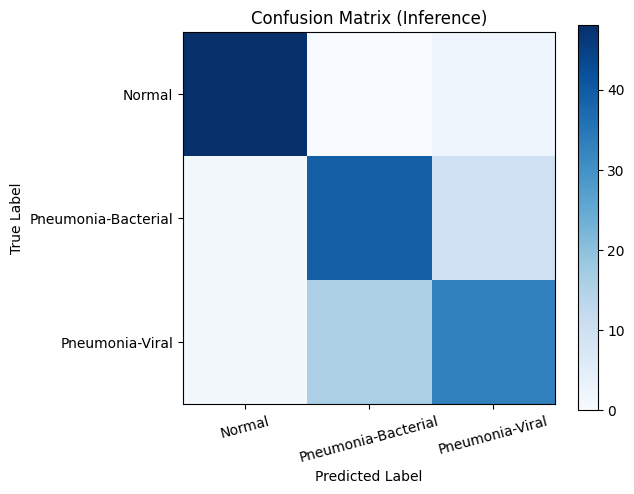

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Konversi label ke bentuk numerik
y_true = df_results["True Label"]
y_pred = df_results["Predicted Label"]

# Akurasi inferensi
acc = accuracy_score(y_true, y_pred)
print(f"\n🔹 Inference Accuracy: {acc:.4f}\n")

# Classification report
print("🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Inference)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(classes)), classes, rotation=15)
plt.yticks(range(len(classes)), classes)
plt.colorbar()
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/CAPSTONE/Data/inference_results_vgg16_finetuned.csv"
df_results.to_csv(save_path, index=False)
print(f"✅ Inference results saved at: {save_path}")


✅ Inference results saved at: /content/drive/MyDrive/CAPSTONE/Data/inference_results_vgg16_finetuned.csv
